# Shift Scheduling

An article entitled ["Modeling and optimization of a weekly workforce with Python and Pyomo"](https://towardsdatascience.com/modeling-and-optimization-of-a-weekly-workforce-with-python-and-pyomo-29484ba065bb) by [Christian Carballo Lozano](https://medium.com/@ccarballolozano) posted on the [Towards Data Science](https://towardsdatascience.com/) blog showed how to build a Pyomo model to schedule weekly shifts for a small campus food store. The article was primarily intended as a tutorial introduction to Pyomo (see the [github](https://github.com/ccarballolozano/blog-post-codes/blob/master/Modeling-and-optimization-of-a-weekly-workforce-with-Python-and-Pyomo/Modeling%20and%20optimization%20of%20a%20weekly%20workforce%20with%20Python%20and%20Pyomo.ipynb) repository for the code). 

Here we revisit the example with a new model demonstrating  use of Pyomo decorators and of Pyomo sets, and how to use the model solution to create useful visualizations and reports for workers and managers.

In [1]:
# install Pyomo and solvers
import requests
import types

url = "https://raw.githubusercontent.com/mobook/MO-book/main/python/helper.py"
helper = types.ModuleType("helper")
exec(requests.get(url).content, helper.__dict__)

helper.install_pyomo()
helper.install_cbc()

pyomo was previously installed
cbc was previously installed


True

## Problem Statement

From the original article:

> A new food store has been opened at the University Campus which will be open 24 hours a day, 7 days a week. Each day, there are three eight-hour shifts. Morning shift is from 6:00 to 14:00, evening shift is from 14:00 to 22:00 and night shift is from 22:00 to 6:00 of the next day.

> During the night there is only one worker while during the day there are two, except on Sunday that there is only one for each shift. Each worker will not exceed a maximum of 40 hours per week and have to rest for 12 hours between two shifts.

> As for the weekly rest days, an employee who rests one Sunday will also prefer to do the same that Saturday.
In principle, there are available ten employees, which is clearly over-sized. The less the workers are needed, the more the resources for other stores.

## Analysis

### Model sets

This problem requires assignment of an unspecified number of workers to a predetermined set of shifts. There are three shifts per day, seven days per week. These observations suggest the need for three ordered sets:

* `WORKERS` with $N$ elements representing workers. $N$ is as input to a function creating an instance of the model.

* `DAYS` with labeling the days of the week.

* `SHIFTS` labeling the shifts each day.

The problem describes additional considerations that suggest the utility of several additional sets.

* `SLOTS` is an ordered set of (day, shift) pairs describing all of the available shifts during the week. 

* `BLOCKS` is an order set of all overlapping 24 hour periods in the week. An element of the set contains the (day, shift) period in the corresponding period. This set will be used to limit worker assignments to no more than one for each 24 hour period.

* `WEEKENDS` is a the set of all (day, shift) pairs on a weekend. This set will be used to implement worker preferences on weekend scheduling.

These additional sets improve the readability of the model.

$$
\begin{align*}
\text{WORKERS} & = \{w_1, w_2, \ldots, w_1\} \text{ set of all workers} \\
\text{DAYS} & = \{\text{Mon}, \text{Tues}, \ldots, \text{Sun}\} \text{ days of the week} \\
\text{SHIFTS} & = \{\text{morning}, \text{evening}, \text{night}\} \text{ 8 hour daily shifts} \\
\text{SLOTS} & = \text{DAYS} \times \text{SHIFTS} \text{ ordered set of all (day, shift) pairs}\\
\text{BLOCKS} & \subset \text{SLOTS} \times \text{SLOTS} \times \text{SLOTS}  \text{ all 24 blocks of consecutive slots} \\
\text{WEEKENDS} & \subset \text{SLOTS} \text{ subset of slots corresponding to weekends} \\
\end{align*}
$$

### Model parameters

$$
\begin{align*}
N & = \text{ number of workers} \\
\text{WorkersRequired}_{d, s} & = \text{ number of workers required for each day, shift pair } (d, s) \\
\end{align*}
$$

### Model decision variables

$$
\begin{align*}
\text{assign}_{w, d, s} & = \begin{cases}1\quad\text{if worker } w \text{ is assigned to day, shift pair } (d,s)\in \text{SLOTS} \\ 0\quad \text{otherwise} \end{cases} \\
\text{weekend}_{w} & = \begin{cases}1\quad\text{if worker } w \text{ is assigned to a weekend day, shift pair } (d,s)\in\text{WEEKENDS} \\ 0\quad \text{otherwise} \end{cases} \\
\text{needed}_{w} & = \begin{cases}1\quad\text{if worker } w \text{ is needed during the week} \\ 0\quad \text{otherwise} \end{cases} \\
\end{align*}
$$

### Model constraints

Assign workers to each shift to meet staffing requirement.

$$\begin{align*}
\\
\sum_{w\in\text{ WORKERS}} \text{assign}_{w, d, s} & \geq \text{WorkersRequired}_{d, s} & \forall (d, s) \in \text{SLOTS} \\
\end{align*}$$

Assign no more than 40 hours per week to each worker.

$$\begin{align*}
\\
8\sum_{d,s\in\text{ SLOTS}} \text{assign}_{w, d, s} & \leq 40 & \forall w \in \text{WORKERS} \\
\\
\end{align*}$$

Assign no more than one shift in each 24 hour period.

$$\begin{align*}
\\
\text{assign}_{w, d_1,s_1} + \text{assign}_{w, d_2, s_2} + \text{assign}_{w, d_3, s_3} & \leq 1 & \forall w \in \text{WORKERS} \\ & & \forall ((d_1, s_1), (d_2, s_2), (d_3, s_3))\in \text{BLOCKS} \\
\\
\end{align*}$$

Indicator if worker has been assigned any shift.

$$\begin{align*}
\\
\sum_{d,s\in\text{ SLOTS}} \text{assign}_{w,d,s} & \leq M_{\text{SLOTS}}\cdot\text{needed}_w & \forall w\in \text{WORKERS} \\
\\
\end{align*}$$

Indicator if worker has been assigned a weekend shift.

$$\begin{align*}
\\
\sum_{d,s\in\text{ WEEKENDS}} \text{assign}_{w,d,s} & \leq M_{\text{WEEKENDS}}\cdot\text{weekend}_w & \forall w\in \text{WORKERS} \\
\\
\end{align*}$$

### Model objective

The model objective is to minimize the overall number of workers needed to fill the shift and work requirements while also attempting to meet worker preferences regarding weekend shift assignments. This is formulated here as an objective for minimizing a weighted sum of the number of workers needed to meet all shift requirements and the number of workers assigned to weekend shifts. The positive weight $\gamma$ determines the relative importance of these two measures of a desirable shift schedule.

$$
\begin{align*}
\min \left(\sum_{w\in\text{ WORKERS}} \text{needed}_w + \gamma\sum_{w\in\text{ WORKERS}} \text{weekend}_w)
\right)\end{align*}
$$

## Pyomo Modeling

In [2]:
import pyomo.environ as pyo

def shift_schedule(N=10, hours=40):
    """return a solved model assigning N workers to shifts"""

    m = pyo.ConcreteModel('workforce')

    # ordered set of avaiable workers
    m.WORKERS = pyo.Set(initialize=[f"W{i:02d}" for i in range(1, N+1)])

    # ordered sets of days and shifts
    m.DAYS = pyo.Set(initialize=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    m.SHIFTS = pyo.Set(initialize=['morning', 'evening', 'night'])

    # ordered set of day, shift time slots 
    m.SLOTS = pyo.Set(initialize = m.DAYS * m.SHIFTS)

    # ordered set of 24 hour time blocks 
    m.BLOCKS = pyo.Set(initialize = [[m.SLOTS.at(i), m.SLOTS.at(i+1), m.SLOTS.at(i+2)] 
                                     for i in range(1, len(m.SLOTS)-1)])
    
    # ordered set of weekend shifts
    m.WEEKENDS = pyo.Set(initialize = m.SLOTS, filter = lambda m, day, shift: day in ['Sat', 'Sun'])

    # parameter of worker requirements
    @m.Param(m.SLOTS)
    def WorkersRequired(m, day, shift):
        if shift in ['night'] or day in ['Sun']:
            return 1
        return 2
    
    # max hours per week per worker
    m.Hours = pyo.Param(mutable=True, default=hours)

    # decision variable: assign[worker, day, shift] = 1 assigns worker to a time slot
    m.assign = pyo.Var(m.WORKERS, m.SLOTS, domain=pyo.Binary)

    # decision variables: weekend[worker] = 1 worker is assigned weekend shift
    m.weekend = pyo.Var(m.WORKERS, domain=pyo.Binary)

    # decision variable: needed[worker] = 1 
    m.needed = pyo.Var(m.WORKERS, domain=pyo.Binary)
                
    # assign a sufficient number of workers for each time slot
    @m.Constraint(m.SLOTS)
    def required_workers(m, day, shift):
        return m.WorkersRequired[day, shift] == sum(m.assign[worker, day, shift] for worker in m.WORKERS)

    # workers limited to forty hours per week assuming 8 hours per shift
    @m.Constraint(m.WORKERS)
    def forty_hour_limit(m, worker):
        return 8*sum(m.assign[worker, day, shift] for day, shift in m.SLOTS) <= m.Hours

    # workers are assigned no more than one time slot per 24 time block
    @m.Constraint(m.WORKERS, m.BLOCKS)
    def required_rest(m, worker, d1, s1, d2, s2, d3, s3):
        return m.assign[worker, d1, s1] + m.assign[worker, d2, s2] + m.assign[worker, d3, s3] <= 1
    
    # determine if a worker is assigned to any shift
    @m.Constraint(m.WORKERS)
    def is_needed(m, worker):
        return sum(m.assign[worker, day, shift] for day, shift in m.SLOTS) <= len(m.SLOTS)*m.needed[worker]

    # determine if a worker is assigned to a weekend shift
    @m.Constraint(m.WORKERS)
    def is__weekend(m, worker):
        return 6*m.weekend[worker] >= sum(m.assign[worker, day, shift] for day, shift in m.WEEKENDS)

    # minimize a blended objective of needed workers and needed weekend workers
    @m.Objective(sense=pyo.minimize)
    def minimize_workers(m):
        return sum(i*m.needed[worker] + 0.1*i*m.weekend[worker] for i, worker in enumerate(m.WORKERS))

    solver = pyo.SolverFactory('cbc')
    solver.solve(m)

    return m

m = shift_schedule(10, 40)

## Visualizing the Solution

Scheduling applications generate a considerable amount of data to be used by the participants. The following cells demonstrate the preparation of charts and reports that can be used to communicate scheduling information to the store management and shift workers.

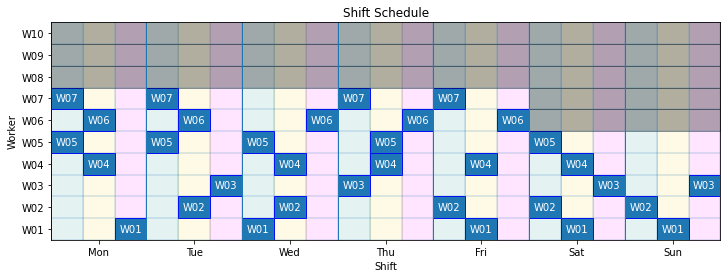

In [3]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def visualize(m):
    
    bw = 1.0
    workers = [worker for worker in m.WORKERS]
    fig, ax = plt.subplots(1, 1, figsize=(12, 1 + 0.3*len(m.WORKERS)))
    ax.set_title('Shift Schedule')
    
    # x axis styling
    ax.set_xlim(0, len(m.SLOTS))
    colors = ['teal', 'gold', 'magenta']
    for i in range(len(m.SLOTS) + 1):
        ax.axvline(i, lw=0.3)
        ax.fill_between([i, i+1], [0]*2, [len(m.WORKERS)]*2, alpha=0.1, color=colors[i%3])
    for i in range(len(m.DAYS) + 1):
        ax.axvline(3*i, lw=1)
    ax.set_xticks([3*i + 1.5 for i in range(len(m.DAYS))])
    ax.set_xticklabels(m.DAYS)
    ax.set_xlabel('Shift')

    # y axis styling
    ax.set_ylim(0, len(m.WORKERS))
    for j in range(len(m.WORKERS) + 1):
        ax.axhline(j, lw=0.3) 
    ax.set_yticks([j + 0.5 for j in range(len(m.WORKERS))])
    ax.set_yticklabels(workers)
    ax.set_ylabel('Worker')
    
    # show shift assignments
    for i, slot in enumerate(m.SLOTS):
        day, shift = slot
        for j, worker in enumerate(m.WORKERS):
            if round(m.assign[worker, day, shift]()):
                ax.add_patch(Rectangle((i, j + (1-bw)/2), 1, bw, edgecolor='b'))
                ax.text(i + 1/2, j + 1/2, worker, ha='center', va='center', color='w')
    
    # display needed and weekend data
    for j, worker in enumerate(m.WORKERS):
        if not m.needed[worker]():
            ax.fill_between([0, len(m.SLOTS)], [j, j], [j+1, j+1], color='k', alpha=0.3)
        if m.needed[worker]() and not m.weekend[worker]():
            ax.fill_between([15, len(m.SLOTS)], [j, j], [j+1, j+1], color='k', alpha=0.3)
        
visualize(m)


## Implementing the Schedule with Reports

Optimal planning models can generate large amounts of data that need to be summarized and communicated to individuals for implementation. 

### Creating a master schedule with categorical data

The following cell creates a pandas DataFrame comprising all active assignments from the solved model. The data consists of all (worker, day, shift) tuples for which the Boolean decision variable m.assign equals one.    

The data is categorical consisting of a unique id for each worker, a day of the week, or the name of a shift. Each of the categories has a natural ordering that should be used in creating reports. This is implemented using the `CategoricalDtype` class.

In [4]:
import pandas as pd

schedule = pd.DataFrame([[w, d, s] for w in m.WORKERS for d, s in m.SLOTS if m.assign[w, d, s]()], 
                        columns=["worker", "day", "shift"])

# create and assign a worker category type
worker_type = pd.CategoricalDtype(categories=m.WORKERS, ordered=True)
schedule["worker"] = schedule["worker"].astype(worker_type)

# create and assign a day category type
day_type = pd.CategoricalDtype(categories=m.DAYS, ordered=True)
schedule["day"] = schedule["day"].astype(day_type)

# create and assign a shift category type
shift_type = pd.CategoricalDtype(categories=m.SHIFTS, ordered=True)
schedule["shift"] = schedule["shift"].astype(shift_type)

# demonstrate sorting and display of the master schedule
schedule.sort_values(by=["day", "shift", "worker"])

,worker,day,shift
19,W05,Mon,morning
29,W07,Mon,morning
14,W04,Mon,evening
24,W06,Mon,evening
0,W01,Mon,night
20,W05,Tue,morning
30,W07,Tue,morning
5,W02,Tue,evening
25,W06,Tue,evening
10,W03,Tue,night


### Reports for workers

Each worker should receive a report detailing their shift assignments. The reports are created by sorting the master schedule by worker, day, and shift, then grouping by worker. 

In [5]:
# sort schedule by worker
schedule = schedule.sort_values(by=["worker", "day", "shift"])

# print worker schedules
for worker, worker_schedule in schedule.groupby('worker'):
    print(f"\n Work schedule for {worker}")
    if len(worker_schedule) > 0:   
        for s in worker_schedule.to_string(index=False).split('\n'):
            print(s)
    else:
        print("   no assigned shifts")


 Work schedule for W01
worker day   shift
   W01 Mon   night
   W01 Wed morning
   W01 Fri evening
   W01 Sat evening
   W01 Sun evening

 Work schedule for W02
worker day   shift
   W02 Tue evening
   W02 Wed evening
   W02 Fri morning
   W02 Sat morning
   W02 Sun morning

 Work schedule for W03
worker day   shift
   W03 Tue   night
   W03 Thu morning
   W03 Sat   night
   W03 Sun   night

 Work schedule for W04
worker day   shift
   W04 Mon evening
   W04 Wed evening
   W04 Thu evening
   W04 Fri evening
   W04 Sat evening

 Work schedule for W05
worker day   shift
   W05 Mon morning
   W05 Tue morning
   W05 Wed morning
   W05 Thu evening
   W05 Sat morning

 Work schedule for W06
worker day   shift
   W06 Mon evening
   W06 Tue evening
   W06 Wed   night
   W06 Thu   night
   W06 Fri   night

 Work schedule for W07
worker day   shift
   W07 Mon morning
   W07 Tue morning
   W07 Thu morning
   W07 Fri morning

 Work schedule for W08
   no assigned shifts

 Work schedule for W09
  

### Reports for store managers

The store managers need reports listing workers by assigned day and shift.

In [6]:
# sort by day, shift, worker
schedule = schedule.sort_values(by=["day", "shift", "worker"])

for day, day_schedule in schedule.groupby(["day"]):
    print(f"\nShift schedule for {day}")
    for shift, shift_schedule in day_schedule.groupby(["shift"]):
        print(f"   {shift} shift: ", end="")
        print(', '.join([worker for worker in shift_schedule["worker"].values]))


Shift schedule for Mon
   morning shift: W05, W07
   evening shift: W04, W06
   night shift: W01

Shift schedule for Tue
   morning shift: W05, W07
   evening shift: W02, W06
   night shift: W03

Shift schedule for Wed
   morning shift: W01, W05
   evening shift: W02, W04
   night shift: W06

Shift schedule for Thu
   morning shift: W03, W07
   evening shift: W04, W05
   night shift: W06

Shift schedule for Fri
   morning shift: W02, W07
   evening shift: W01, W04
   night shift: W06

Shift schedule for Sat
   morning shift: W02, W05
   evening shift: W01, W04
   night shift: W03

Shift schedule for Sun
   morning shift: W02
   evening shift: W01
   night shift: W03


## Suggested Exercises

1. How many workers will be required to operate the food store if all workers are limited to four shifts per week, i.e., 32 hours?  How about 3 shifts or 24 hours per week?

2. Add a second class of workers called "manager".  There needs to be one manager on duty for every shift, that morning shifts require 3 staff on duty, evening shifts 2,
and night shifts 1.

3. Add a third class of workers called "part_time". Part time workers are limited to no more than 30 hours per week.

4. Modify the problem formulation and objective to spread the shifts out amongst all workers, attempting to equalize the total number of assigned shifts, and similar numbers of day, evening, night, and weekend shifts.

5. Find the minimum cost staffing plan assuming managers cost 30 euros per hour + 100 euros per week in fixed benefits, regular workers cost 20 euros per hour plus 80 euros per week in fixed benefits, and part time workers cosst 15 euros per week with no benefits.